In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#  ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


In [ ]:
df = pd.read_csv('bank-full.csv', sep=';')
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
df.shape, df['y'].value_counts()

df.info()
print("\nMissing values per column:\n", df.isnull().sum())

df['y'] = df['y'].map({'yes': 1, 'no': 0})
df['y'].value_counts()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB

Missing values per column:
 age          0
job          0
marital      0
education    0
default   

,count
y,
0,39922
1,5289


In [ ]:
#  features and target
X = df.drop('y', axis=1)
y = df['y']

# One-hot encode all categorical columns
X_encoded = pd.get_dummies(X, drop_first=True)

X_encoded.shape


(45211, 42)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

X_train.shape, X_test.shape, y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)


((31647, 42),
 (13564, 42),
 y
 0    0.883022
 1    0.116978
 Name: proportion, dtype: float64,
 y
 0    0.882999
 1    0.117001
 Name: proportion, dtype: float64)

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

results = []

def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # scores/probabilities for ROC-AUC
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    auc  = roc_auc_score(y_test, y_scores)
    cm   = confusion_matrix(y_test, y_pred)

    print("="*60)
    print(f"{model_name}")
    print("="*60)
    print("Confusion matrix (rows = true, cols = predicted):")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-score : {f1:.3f}")
    print(f"ROC-AUC  : {auc:.3f}\n")

    #  metrics for comparison table
    results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1_score": f1,
        "ROC_AUC": auc
    })

    return model, y_pred, y_scores


In [ ]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

log_reg_model, y_pred_lr, y_scores_lr = train_and_evaluate(
    log_reg,
    X_train_scaled,
    y_train,
    X_test_scaled,
    y_test,
    model_name="Logistic Regression"
)


Logistic Regression
Confusion matrix (rows = true, cols = predicted):
[[10201  1776]
 [  308  1279]]

Classification report:
              precision    recall  f1-score   support

           0      0.971     0.852     0.907     11977
           1      0.419     0.806     0.551      1587

    accuracy                          0.846     13564
   macro avg      0.695     0.829     0.729     13564
weighted avg      0.906     0.846     0.866     13564

Accuracy : 0.846
Precision: 0.419
Recall   : 0.806
F1-score : 0.551
ROC-AUC  : 0.907



In [ ]:
from sklearn.model_selection import train_test_split

X_train_svm, _, y_train_svm, _ = train_test_split(
    X_train_scaled,
    y_train,
    test_size=0.6,
    stratify=y_train,
    random_state=42
)

svm_clf = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    probability=False,
    random_state=42
)

svm_model, y_pred_svm, y_scores_svm = train_and_evaluate(
    svm_clf,
    X_train_svm,
    y_train_svm,
    X_test_scaled,
    y_test,
    model_name="SVM (RBF, subset)"
)


SVM (RBF, subset)
Confusion matrix (rows = true, cols = predicted):
[[10266  1711]
 [  315  1272]]

Classification report:
              precision    recall  f1-score   support

           0      0.970     0.857     0.910     11977
           1      0.426     0.802     0.557      1587

    accuracy                          0.851     13564
   macro avg      0.698     0.829     0.733     13564
weighted avg      0.907     0.851     0.869     13564

Accuracy : 0.851
Precision: 0.426
Recall   : 0.802
F1-score : 0.557
ROC-AUC  : 0.908



In [ ]:
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model, y_pred_rf, y_scores_rf = train_and_evaluate(
    rf_clf,
    X_train,
    y_train,
    X_test,
    y_test,
    model_name="Random Forest"
)


Random Forest
Confusion matrix (rows = true, cols = predicted):
[[11741   236]
 [ 1064   523]]

Classification report:
              precision    recall  f1-score   support

           0      0.917     0.980     0.948     11977
           1      0.689     0.330     0.446      1587

    accuracy                          0.904     13564
   macro avg      0.803     0.655     0.697     13564
weighted avg      0.890     0.904     0.889     13564

Accuracy : 0.904
Precision: 0.689
Recall   : 0.330
F1-score : 0.446
ROC-AUC  : 0.928



In [ ]:
metrics_df = pd.DataFrame(results)
metrics_df


,Model,Accuracy,Precision,Recall,F1_score,ROC_AUC
0,Logistic Regression,0.846358,0.418658,0.805923,0.551056,0.907442
1,"SVM (RBF, subset)",0.850634,0.426416,0.801512,0.556674,0.908239
2,Random Forest,0.904158,0.689065,0.329553,0.445865,0.927924


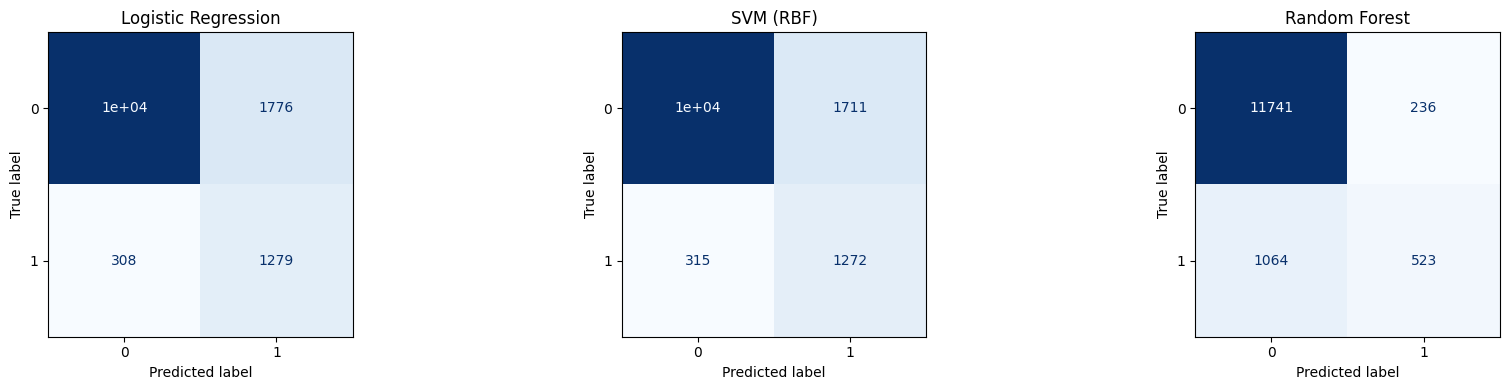

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for ax, model, y_pred, title in zip(
    axes,
    [log_reg_model, svm_model, rf_model],
    [y_pred_lr, y_pred_svm, y_pred_rf],
    ["Logistic Regression", "SVM (RBF)", "Random Forest"]
):
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=[0, 1],
        cmap='Blues',
        ax=ax,
        colorbar=False
    )
    ax.set_title(title)

plt.tight_layout()
plt.show()


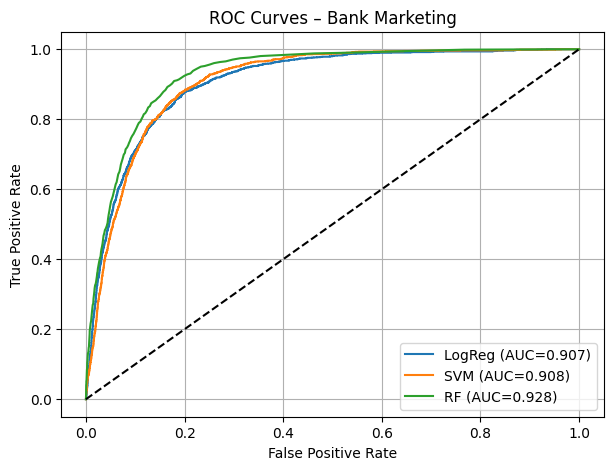

In [ ]:
fpr_lr, tpr_lr, _   = roc_curve(y_test, y_scores_lr)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_scores_svm)
fpr_rf, tpr_rf, _   = roc_curve(y_test, y_scores_rf)

plt.figure(figsize=(7,5))
plt.plot(fpr_lr,  tpr_lr,  label=f"LogReg (AUC={metrics_df.loc[0,'ROC_AUC']:.3f})")
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC={metrics_df.loc[1,'ROC_AUC']:.3f})")
plt.plot(fpr_rf,  tpr_rf,  label=f"RF (AUC={metrics_df.loc[2,'ROC_AUC']:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Bank Marketing")
plt.legend()
plt.grid(True)
plt.show()
